In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.stats import ttest_rel

from numpy import logspace, random
import pickle
from scipy.stats import rankdata
from os.path import basename

import shap
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns
reload(TraitData)
sns.set()
sns.set(font_scale=1.5)

cv = KFold(n_splits=10)

# try:
#     SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
#     np.random.set_state(SAVED_STATE)
# except Exception as e:
#     SAVED_STATE = False
    

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Feature Interpretation Across Methods: A Study <small> Tony Cannistra | CSE546 Au17 Final Project </small></h1>
We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'name' : "Alpine Plants",
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode"]
}

plantsData_extendedDrop = deepcopy(plantsData)
plantsData_extendedDrop['name'] = "Alpine Plants-extendeddrop"
plantsData_extendedDrop.get('drop_features').extend(["Bio1_mean_nosyn",
                                                 "Bio1_std_nosyn",
                                                 "Bio1_var_nosyn", 
                                                 "Bio1_mean_inclsyn",
                                                 "Bio1_std_inclsyn",
                                                 "Bio1_var_inclsyn"])

mammalData = {
    'name' : "Mammals",
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"]
}

mammalData_extendedDrop = deepcopy(mammalData)
mammalData_extendedDrop['name'] = "Mammals-extendeddrop"
mammalData_extendedDrop.get("drop_features").extend(["Bio1_mean",
                                                     "Daily01_0",
                                                     "Daily01_1",
                                                     "Annual01_0",
                                                     "Annual01_1",
                                                     "Food01_0",
                                                     "Food01_1"])

triennialMarineData = {
    'name' : "Triennial Marine",
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ]
}

triennialMarineData_extendedDrop = deepcopy(triennialMarineData)
triennialMarineData_extendedDrop['name'] = "triennialMarineData-extendeddrop"
triennialMarineData_extendedDrop.get("drop_features").extend(["Electrogenic_Electrosensing only",
                                                              "Electrogenic_electrosensing only",
                                                              "Electrogenic_no special ability",
                                                              "Electrogenic_strongly discharging",
                                                              "Electrogenic_weakly discharging"])

all_mses = {}
rankings = []
MSEs = []


### Select, Load, and Normalize Dataset

In [3]:
dataset = triennialMarineData_extendedDrop
dsname = dataset['name'].replace(" ", "-")

dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print("\n".join(td.feature_names))



76


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,DepthRangeDeep,Vulnerability,Length,UsedforAquaculture_commercial,UsedforAquaculture_likely future use,UsedforAquaculture_never/rarely,DemersPelag_bathydemersal,DemersPelag_benthopelagic,DemersPelag_demersal,DemersPelag_pelagic-neritic,DemersPelag_pelagic-oceanic,DemersPelag_reef-associated,LTypeMaxM_FL,LTypeMaxM_SL,LTypeMaxM_TL,Fresh_-1,Fresh_0,Brack_-1,Brack_0,Saltwater_-1
0,-1.080200,-1.473061,-0.817193,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1
1,-0.798251,-0.248015,-0.017934,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1
2,3.977626,0.079575,0.644353,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1
3,1.227181,-0.138601,-0.123297,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,0.544365,0.591477,0.102482,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1


(76, 20)
DepthRangeDeep
Vulnerability
Length
UsedforAquaculture_commercial
UsedforAquaculture_likely future use
UsedforAquaculture_never/rarely
DemersPelag_bathydemersal
DemersPelag_benthopelagic
DemersPelag_demersal
DemersPelag_pelagic-neritic
DemersPelag_pelagic-oceanic
DemersPelag_reef-associated
LTypeMaxM_FL
LTypeMaxM_SL
LTypeMaxM_TL
Fresh_-1
Fresh_0
Brack_-1
Brack_0
Saltwater_-1


In [4]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )
X_train, X_test, Y_train, Y_test = train_test_split(td.X, td.Y, train_size=0.60)

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Learning

In [5]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

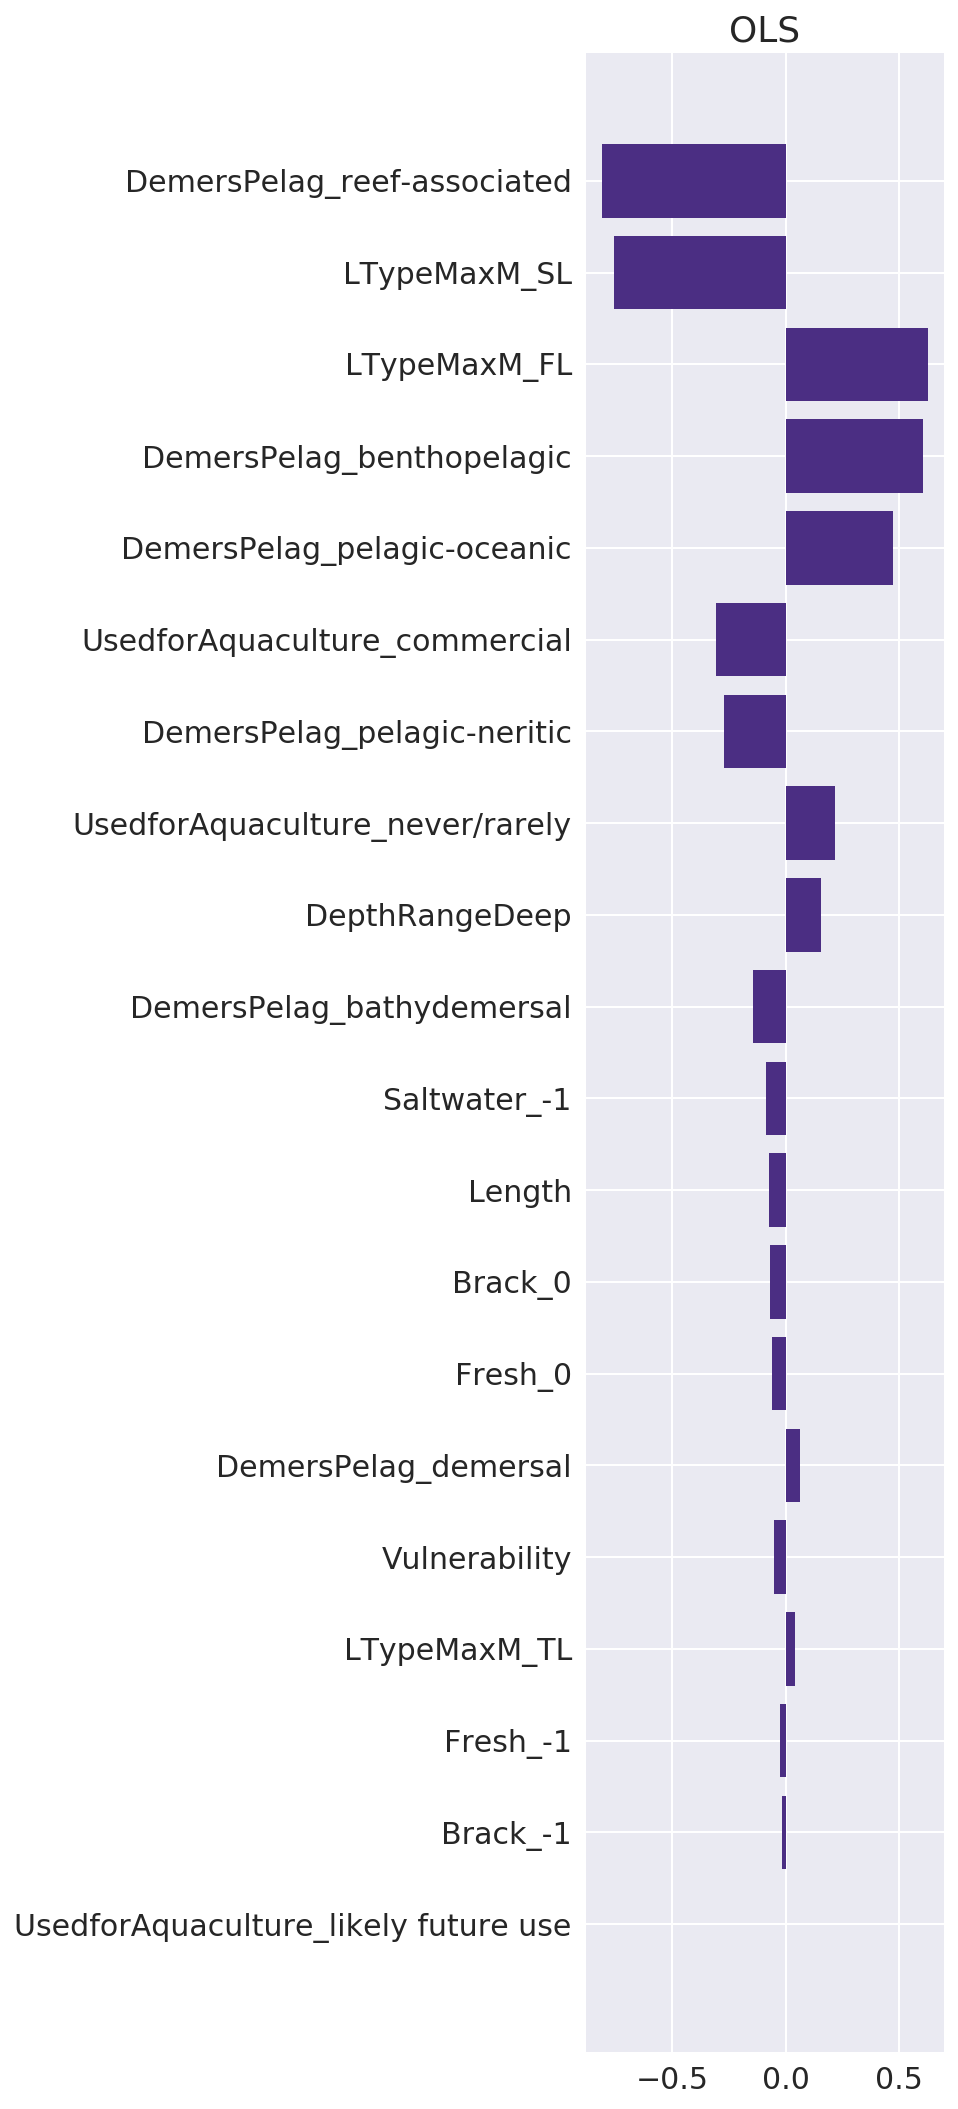

In [6]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)
    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)

plot_importance(mean_coefs,
                td.feature_names, "OLS",
                save="{}_ols-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("OLS", ols_mses))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


#### Ridge CV

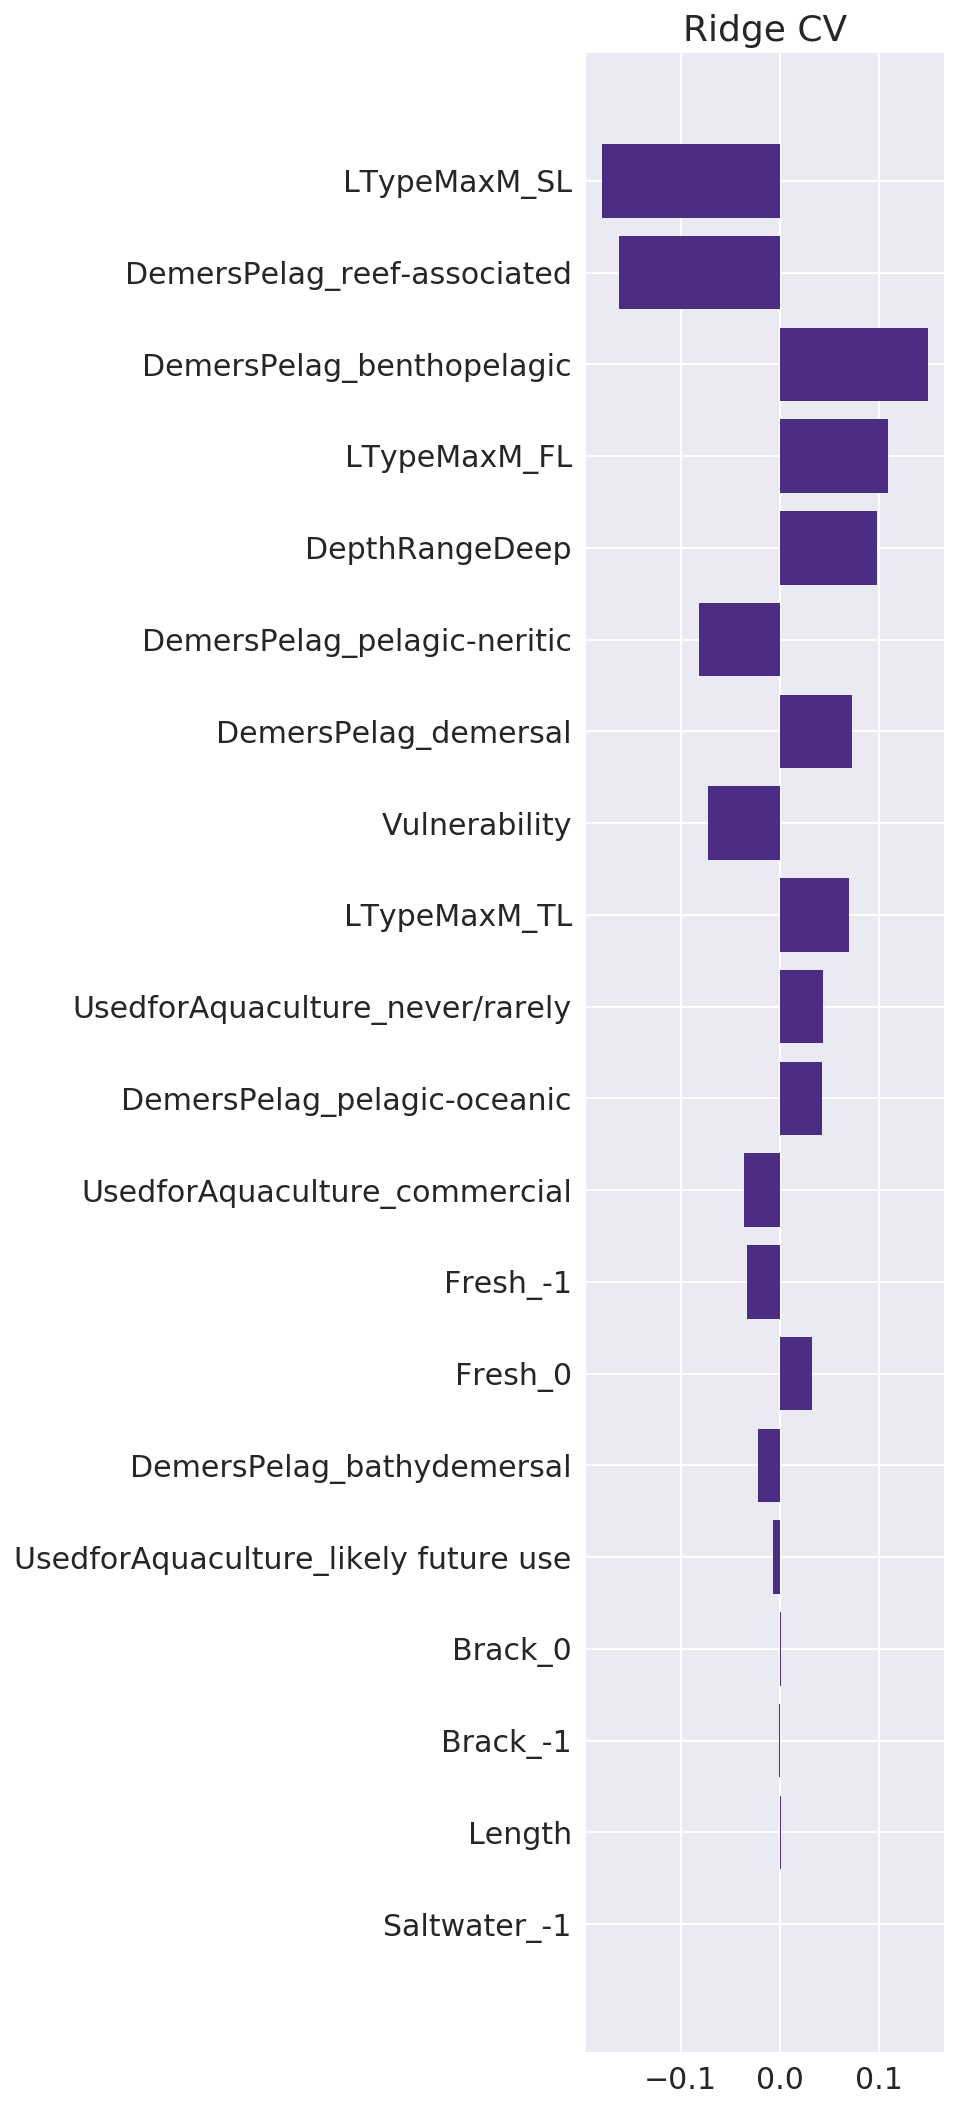

In [7]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
               save="{}_ridge-ranks.png".format(dsname))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))


#### Kernel Ridge

In [8]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



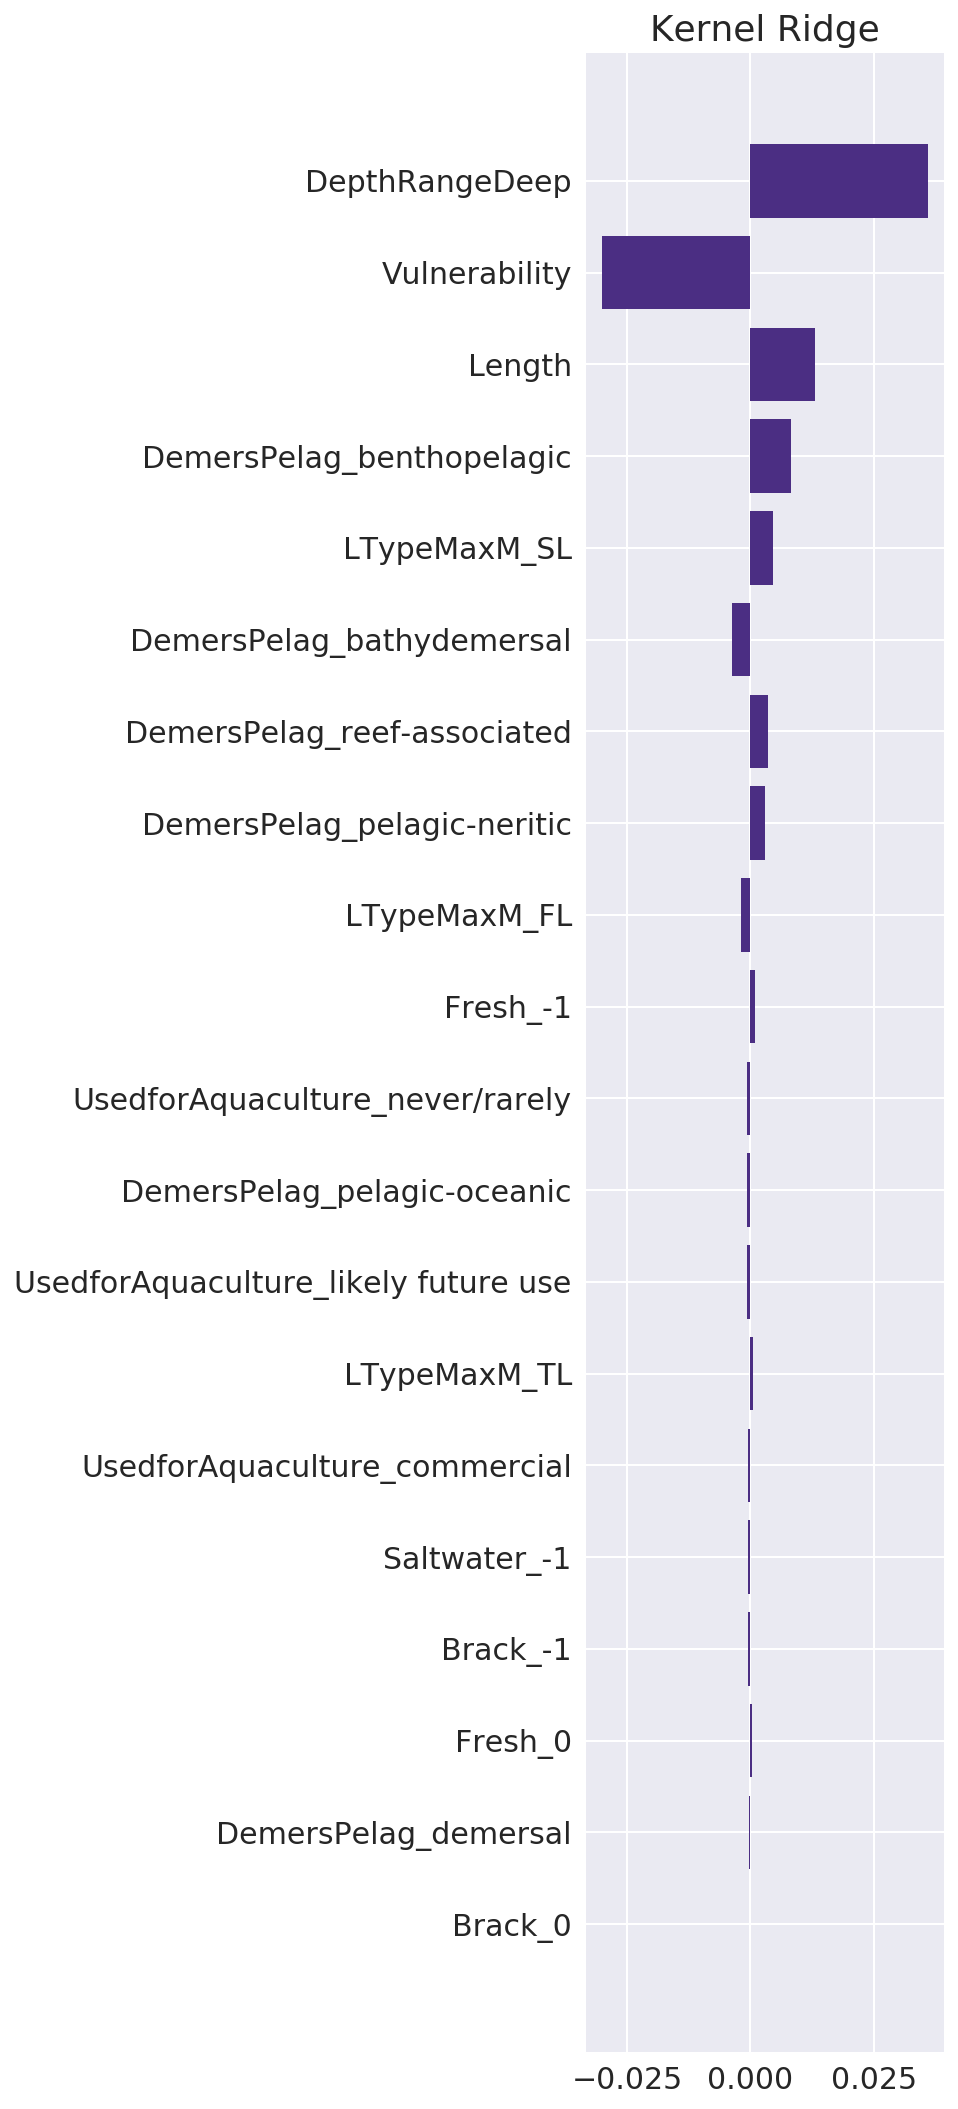

In [9]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge", 
               save="{}_kernelridge-ranks.png".format(dsname))#, std=std_coefs)
MSEs.append(("Kernel Ridge", kernel_ridge_mses))

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

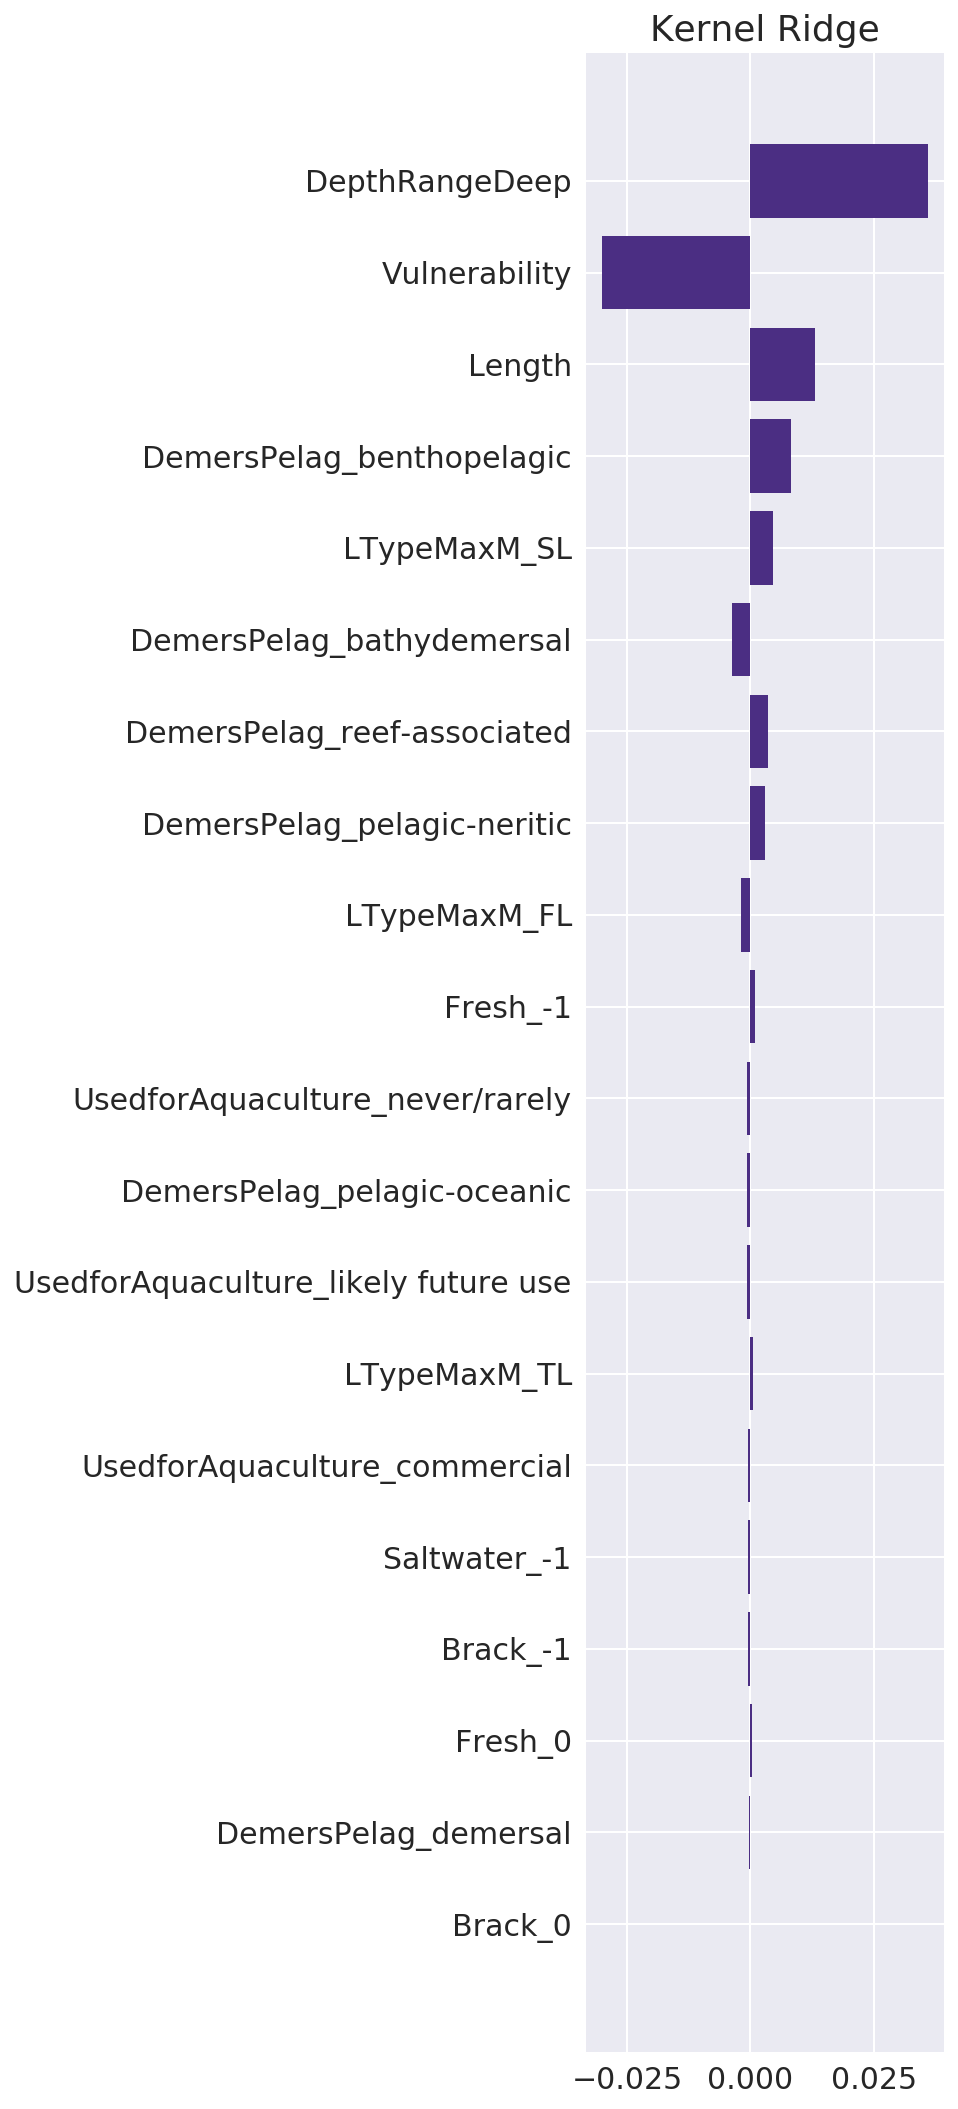

In [11]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge", save="{}_kernelridge-nostd-ranks.png".format(dsname))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

### Trees

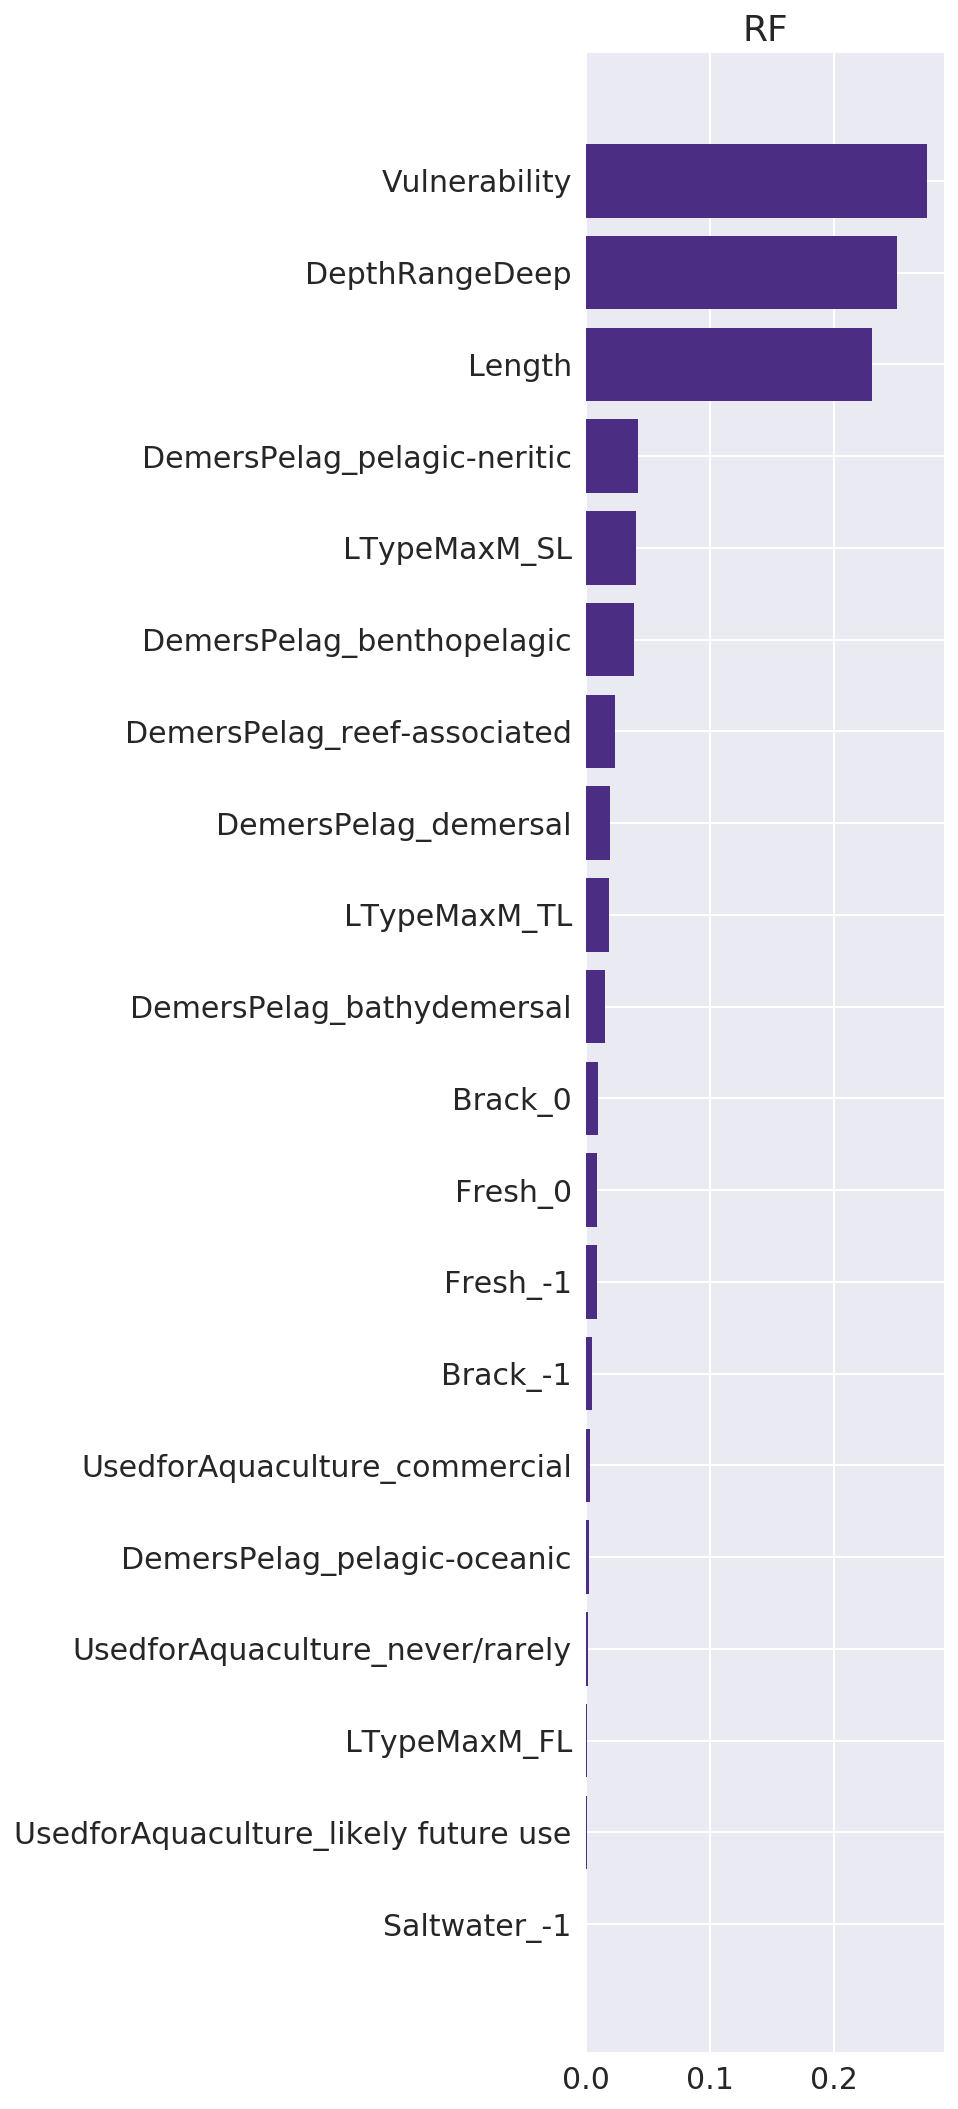

In [12]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
plot_importance(mean_coefs,
                td.feature_names, "RF",
                save="{}_rf-ranks.png".format(dsname))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [13]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    shapdata = shap.DenseData(X_train, td.feature_names)
    explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
    svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)


CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init


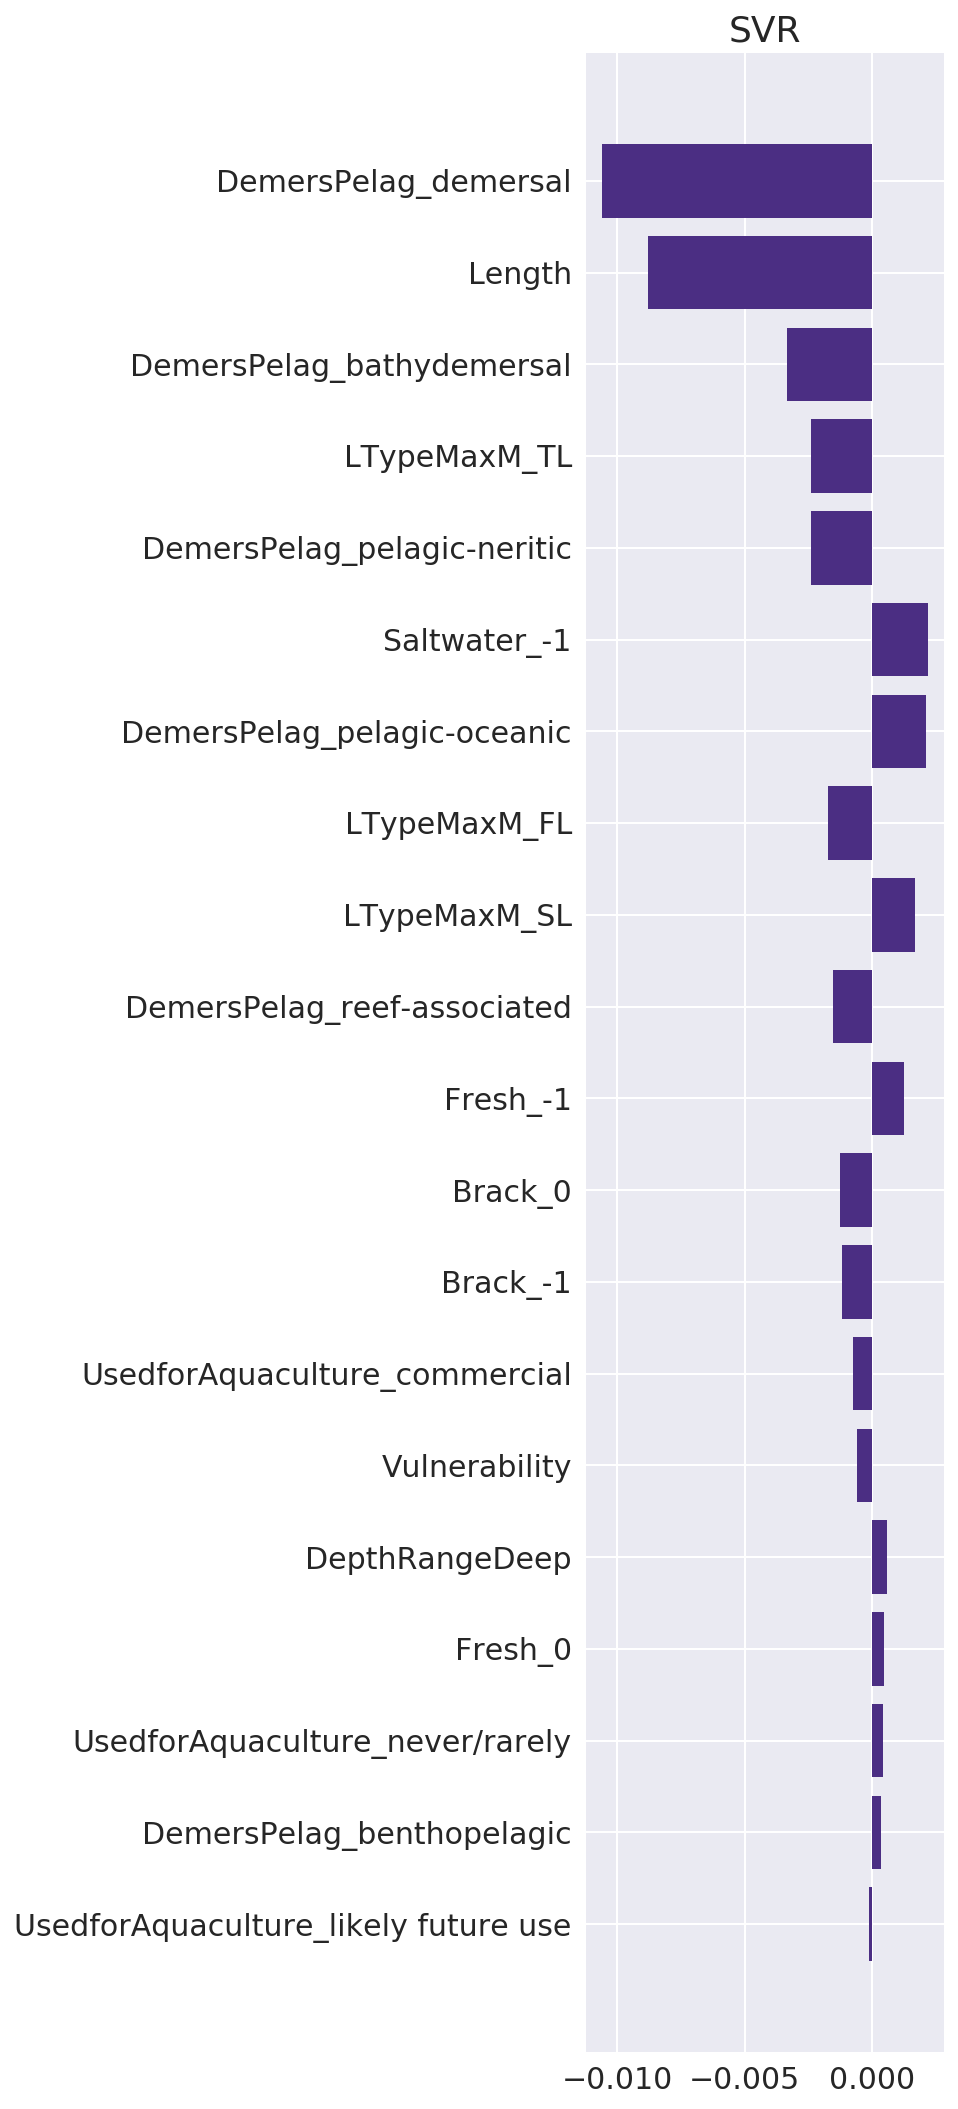

In [14]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)



MSEs.append(("SVR", svr_mses))
plot_importance(mean_coefs,
                td.feature_names, "SVR",
                save="{}_svr-ranks.png".format(dsname))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

In [15]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


In [16]:
results.sort_values(by=['mean'])

Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,mean
DemersPelag_reef-associated,0,1,6,6,4,9,4.333333
DepthRangeDeep,8,4,0,0,1,15,4.666667
LTypeMaxM_SL,1,0,4,4,13,8,5.000000
DemersPelag_benthopelagic,3,2,3,3,3,18,5.333333
DemersPelag_pelagic-neritic,6,5,7,7,5,4,5.666667
Length,11,18,2,2,2,1,6.000000
LTypeMaxM_FL,2,3,8,8,10,7,6.333333
Vulnerability,15,7,1,1,0,14,6.333333
DemersPelag_bathydemersal,9,14,5,5,8,2,7.166667
DemersPelag_pelagic-oceanic,4,10,11,11,18,6,10.000000


In [17]:
results.sort_values(by=['mean'])


Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,mean
DemersPelag_reef-associated,0,1,6,6,4,9,4.333333
DepthRangeDeep,8,4,0,0,1,15,4.666667
LTypeMaxM_SL,1,0,4,4,13,8,5.000000
DemersPelag_benthopelagic,3,2,3,3,3,18,5.333333
DemersPelag_pelagic-neritic,6,5,7,7,5,4,5.666667
Length,11,18,2,2,2,1,6.000000
LTypeMaxM_FL,2,3,8,8,10,7,6.333333
Vulnerability,15,7,1,1,0,14,6.333333
DemersPelag_bathydemersal,9,14,5,5,8,2,7.166667
DemersPelag_pelagic-oceanic,4,10,11,11,18,6,10.000000


In [18]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  


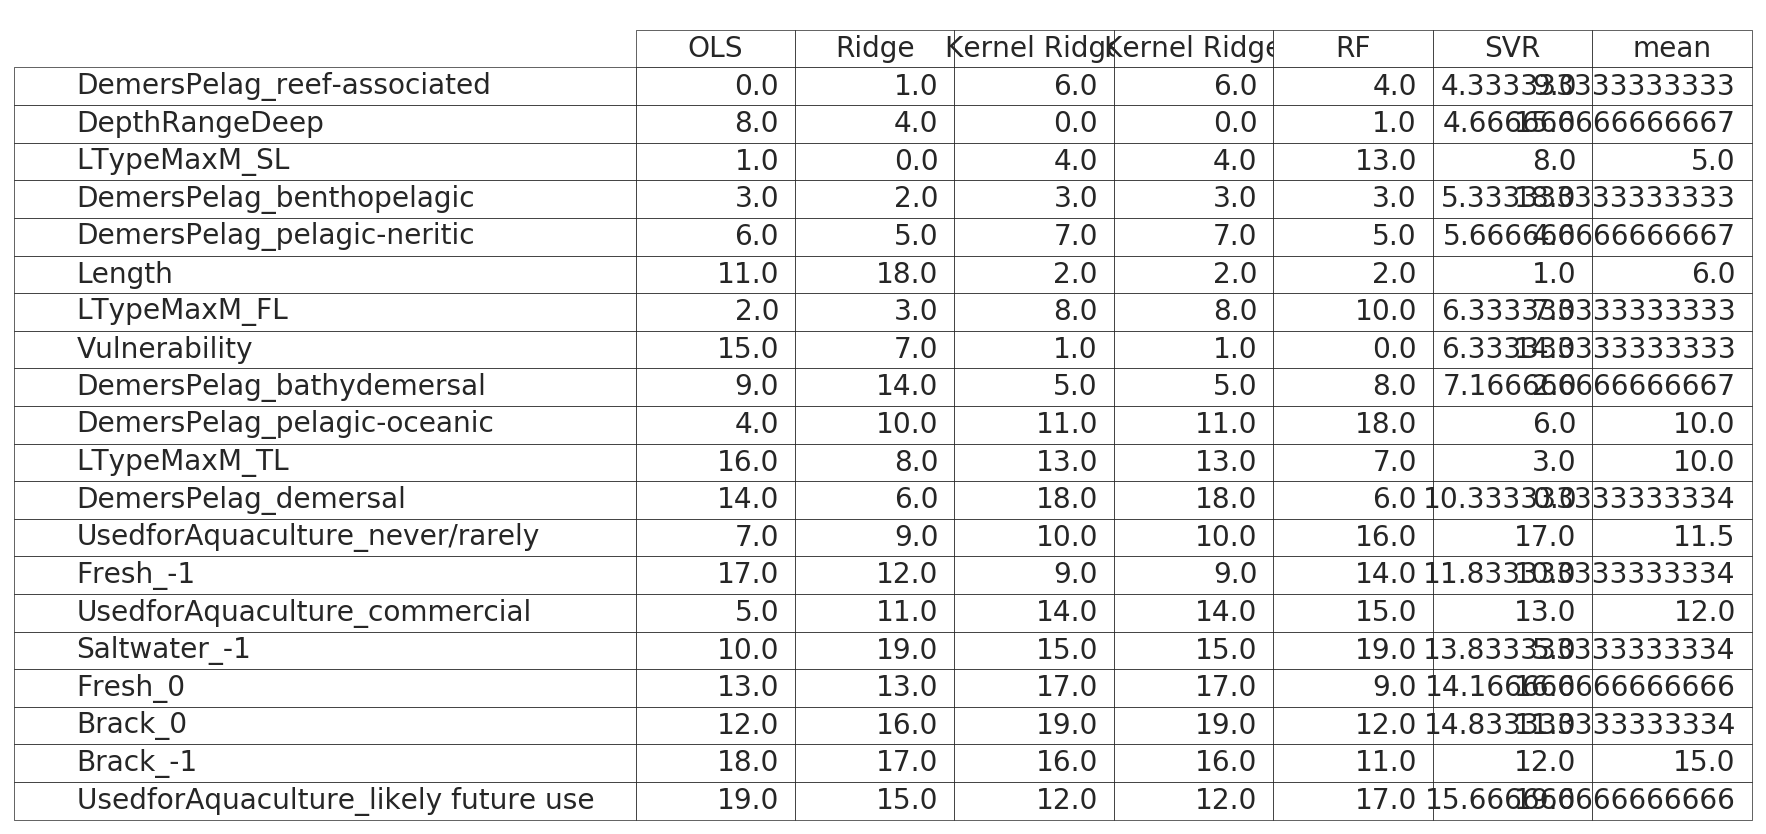

In [19]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

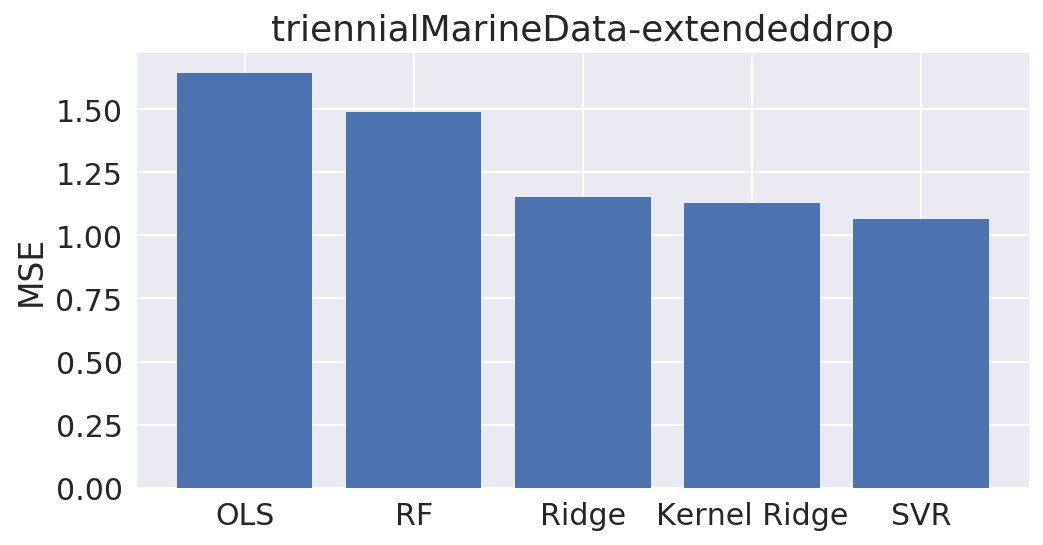

In [26]:

fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])#, yerr=error_stds)
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title(dataset['name'])
plt.savefig("{}-msecompare.png".format(dsname), dpi=200)

In [21]:
all_mses[dataset['name']] = MSEs


In [22]:
pd.DataFrame(MSEs, columns=['method', 'MSEs']).to_csv("{}-mseraw.csv".format(dsname))

In [23]:
from itertools import combinations
msedict = dict(MSEs)
list(combinations(msedict.keys(), 2))

[('OLS', 'Ridge'),
 ('OLS', 'Kernel Ridge'),
 ('OLS', 'RF'),
 ('OLS', 'SVR'),
 ('Ridge', 'Kernel Ridge'),
 ('Ridge', 'RF'),
 ('Ridge', 'SVR'),
 ('Kernel Ridge', 'RF'),
 ('Kernel Ridge', 'SVR'),
 ('RF', 'SVR')]

In [24]:
significance = list(map(lambda x: (x, ttest_rel(msedict[x[0]], msedict[x[1]]).pvalue), combinations(msedict.keys(),2)))
significance = pd.DataFrame(significance, columns=["Combination", "pvalue"])
significance[significance.pvalue < 0.05]

,Combination,pvalue
0,"(OLS, Ridge)",0.008880
1,"(OLS, Kernel Ridge)",0.005717
3,"(OLS, SVR)",0.009985
5,"(Ridge, RF)",0.038446
7,"(Kernel Ridge, RF)",0.041835
9,"(RF, SVR)",0.013657


In [25]:
all_mses

{'triennialMarineData-extendeddrop': [('OLS',
   [0.9948322262088056,
    3.9296896063612143,
    1.5674365149592608,
    1.9170760155207143,
    3.953926060729926,
    0.6316104015651003,
    0.9329072069595418,
    0.5797926124181928,
    0.6385977044273942,
    1.2805450698037504]),
  ('Ridge',
   [0.7997941881444569,
    3.0359460268129013,
    0.8687957969389544,
    0.8463959122387186,
    2.741220042798618,
    0.5844191098908114,
    0.42740185032574607,
    0.6712493730719615,
    0.6784039675967943,
    0.8522275792934114]),
  ('Kernel Ridge',
   [0.7712803103752224,
    3.1118528597410013,
    0.7809672987901741,
    0.7768169415755898,
    2.8007668017104077,
    0.5849461333513678,
    0.4279641095082896,
    0.6150316987831971,
    0.6394466891969822,
    0.7693045929493468]),
  ('RF',
   [1.2933623529945102,
    2.5979978661758105,
    1.1767125076877276,
    1.088532734847296,
    2.907512393453565,
    0.6124820606168518,
    0.8638993993968038,
    1.0200075639404023,